# Modèle SVM pour détecter les risques de cancer cervical
par Binh Minh TRAN

## 1. Télechargement des packages nécessaires

In [31]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from fonctionUtile import *

## 2. Importation des ensembles d'entraînement et de test (validation croisée)

In [2]:
with open('variables.pkl', 'rb') as f:
    (fold_indices, df, 
                 X_train_1, Y_train_1, X_train_2, Y_train_2, 
                 X_train_3, Y_train_3, X_train_4, Y_train_4, 
                 X_train_5, Y_train_5, X_train_6, Y_train_6, 
                 X_test_1, Y_test_1, X_test_2, Y_test_2, 
                 X_test_3, Y_test_3, X_test_4, Y_test_4,
                 X_test_5, Y_test_5, X_test_6, Y_test_6) = pickle.load(f)

In [3]:
list_X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_train_6]
list_Y_train = [Y_train_1, Y_train_2, Y_train_3, Y_train_4, Y_train_5, Y_train_6]
list_X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5, X_test_6]
list_Y_test = [Y_test_1, Y_test_2, Y_test_3, Y_test_4, Y_test_5, Y_test_6]

## 3. PCA

Avec 19 attributs, ce qui représente un nombre relativement élevé pour un modèle SVM, il est nécessaire d'envisager une réduction de la dimensionnalité des données.

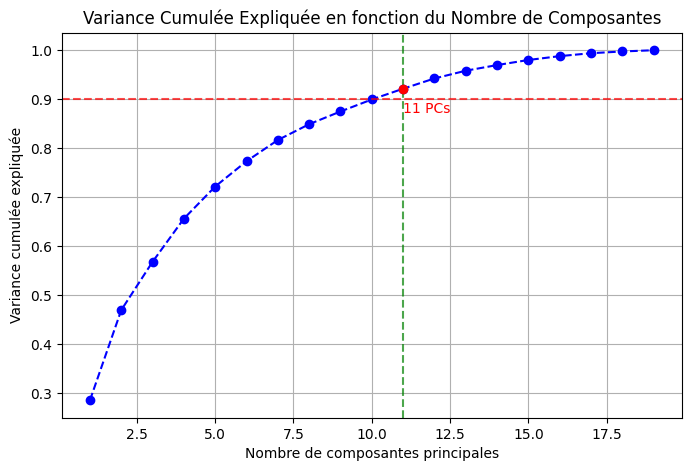

In [5]:
plot_variance_cumul_explique(X_train_norm_1, n_components=None)

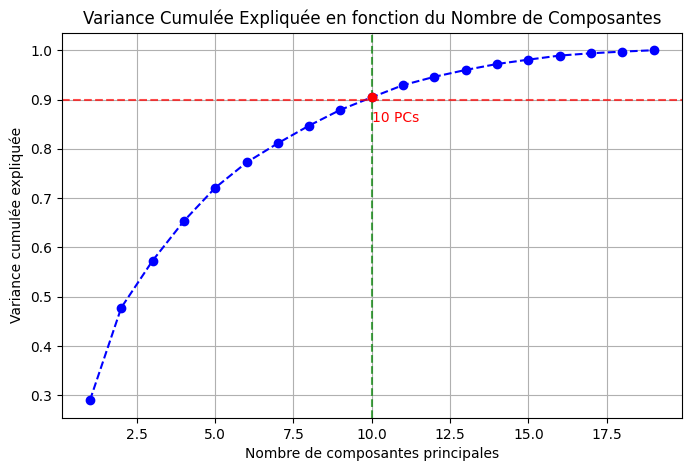

In [6]:
plot_variance_cumul_explique(X_train_norm_2, n_components=None)

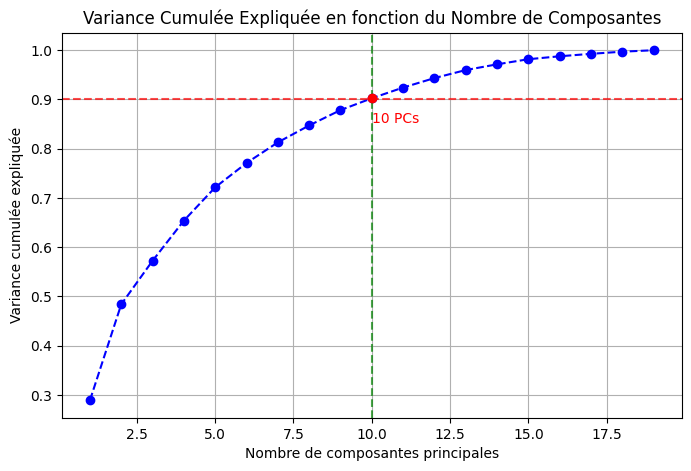

In [7]:
plot_variance_cumul_explique(X_train_norm_3, n_components=None)

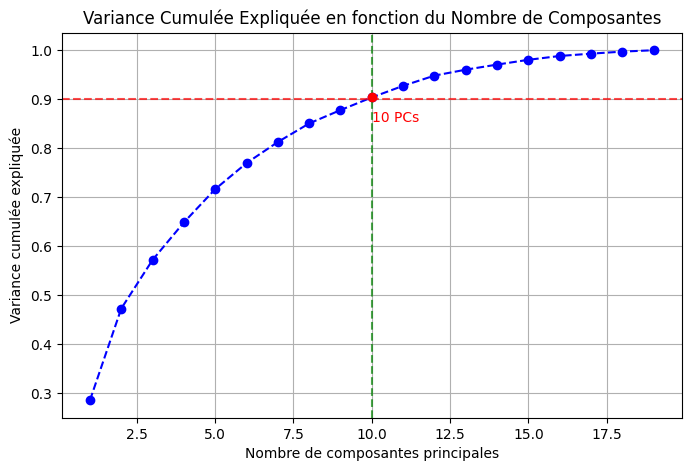

In [8]:
plot_variance_cumul_explique(X_train_norm_4, n_components=None)

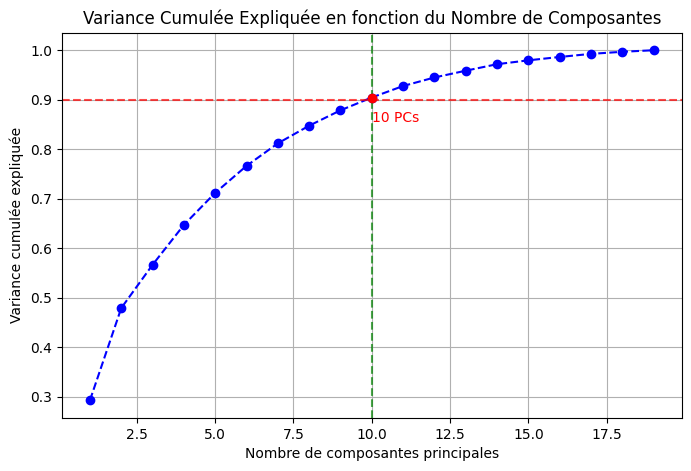

In [9]:
plot_variance_cumul_explique(X_train_norm_5, n_components=None)

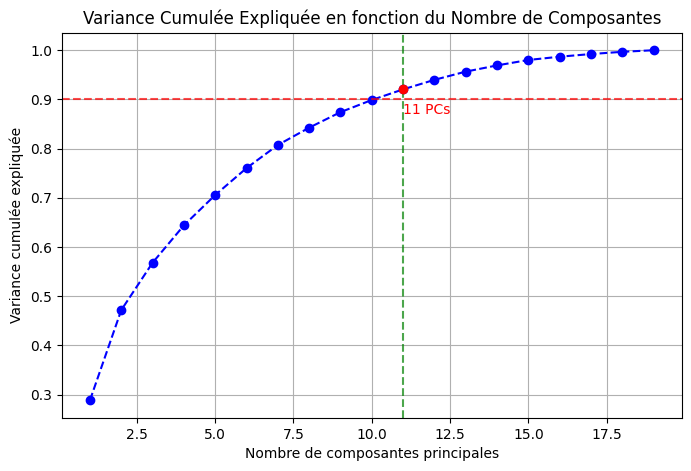

In [10]:
plot_variance_cumul_explique(X_train_norm_6, n_components=None)

Pour conserver 90 % de l'information, les ensembles d'entraînement des 6 folds retiennent 10 ou 11 des 19 composantes principales, ce qui s'explique par leurs structures différentes après normalisation.

## 4. SVM

In [47]:
scores = []
best_C_values = []

# Boucle sur les 6 plis (folds)
for i in range(0, 6):
    X_train, X_test = list_X_train[i], list_X_test[i]
    y_train, y_test = list_Y_train[i], list_Y_test[i]
    
    # Normalisation des données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) 
    X_test_scaled = scaler.transform(X_test)        
    
    pca = PCA(n_components=0.9)  # Conserver 90 % de la variance
    X_train_pca = pca.fit_transform(X_train_scaled)  
    X_test_pca = pca.transform(X_test_scaled)        
    
    # Initialisation du modèle SVC avec noyau RBF
    svc = SVC(kernel='rbf')
    # Define the parameter grid to search
    param_grid = {
    'C': [0.1, 1, 3, 10, 100],       
    'gamma': [0.001, 0.01, 0.1, 1]} 
    
    # Recherche par grille avec validation croisée (5 plis internes)
    grid_search = GridSearchCV(svc, param_grid, cv=6, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)  

    # Récupérer la meilleure valeur de C et le meilleur modèle
    best_C = grid_search.best_params_['C']
    best_model = grid_search.best_estimator_
    best_C_values.append(best_C)  # Stocker la meilleure valeur de C
    
    # Prédiction sur les données de test et calcul du score
    y_pred = best_model.predict(X_test_pca)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)
    
    # Afficher les résultats pour chaque pli
    print(f"Fold {i+1}: Meilleure valeur de C = {best_C}, Précision = {score}")

# Résultats globaux
print("Précision moyenne sur tous les plis:", np.mean(scores))
print("Meilleures valeurs de C pour chaque pli:", best_C_values)

Fold 1: Meilleure valeur de C = 100, Précision = 1.0
Fold 2: Meilleure valeur de C = 100, Précision = 0.9166666666666666
Fold 3: Meilleure valeur de C = 1, Précision = 0.75
Fold 4: Meilleure valeur de C = 3, Précision = 0.8333333333333334
Fold 5: Meilleure valeur de C = 10, Précision = 0.9166666666666666
Fold 6: Meilleure valeur de C = 3, Précision = 0.8333333333333334
Précision moyenne sur tous les plis: 0.875
Meilleures valeurs de C pour chaque pli: [100, 100, 1, 3, 10, 3]


In [48]:
print(scores)

[1.0, 0.9166666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334]


In [49]:
np.mean(scores)

0.875